## Win/Loss Betting Model
https://discourse.pymc.io/t/applying-timeseries-over-periodic-data/529

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data = pd.read_csv('data.csv', index_col=0).reset_index(drop=True)

In [80]:
data.head()

,Date,Team 1 ID,Team 2 ID,winner
0,2016Q3,4674,4559,4674
1,2016Q3,5974,6673,6673
2,2016Q3,6665,5310,6665
3,2016Q3,5995,5395,5995
4,2016Q3,5395,5995,5995


In [79]:
data.tail()

,Date,Team 1 ID,Team 2 ID,winner
5752,2017Q4,6290,6301,6290
5753,2017Q4,6673,5974,6673
5754,2017Q4,6301,6290,6290
5755,2017Q4,6667,4411,6667
5756,2017Q4,7010,6673,7010


In [2]:
teams = np.sort(np.unique(np.concatenate([data['Team 1 ID'], data['Team 2 ID']])))
periods = data.Date.unique()
tmap = {v:k for k,v in dict(enumerate(teams)).items()}
pmap = {v:k for k,v in dict(enumerate(periods)).items()}
n_teams = len(teams)
n_periods = len(periods)
print('Number of Teams: %i ' % n_teams)
print('Number of Matches: %i ' % len(data))
print('Number of Periods: %i '% n_periods)

Number of Teams: 288 
Number of Matches: 5757 
Number of Periods: 6 


## Pymc Model

Determining Binary Win Loss: $wl_{t,i,j}$
$$
\rho \sim Beta(5,8) \\
\omega_k \sim HC(0.5) \\
\sigma \sim HC(0.5) \\
R_{k,0} \sim N(0, \omega^2) \\
R_{k,t} \sim N(\rho R_{k,t-1}, \sigma^2) \\
wl_{t,i,j} \sim B(p = 0.5\text{Tanh}(R_{i,t}-R_{j,t})+0.5) \\
$$

In [8]:
import pymc3 as pm
import theano.tensor as tt

obs_team_1 = data['Team 1 ID'].map(tmap).values
obs_team_2 = data['Team 2 ID'].map(tmap).values
obs_period = data['Date'].map(pmap).values
obs_wl = (data['Team 1 ID'] == data['winner']).values

## Baseline model

In [30]:
with pm.Model() as rating_model0:
    time_rating = pm.Normal('rating_all', 0., 1., shape=(n_periods, n_teams))
    
    diff = time_rating[obs_period, obs_team_1] - time_rating[obs_period, obs_team_2]
    p = 0.5*pm.math.tanh(diff) + 0.5
    
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    
    trace0 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [01:19<00:00, 25.01it/s]


#### Check fit using posterior prediction check

In [33]:
ppc0 = pm.sample_ppc(trace0, samples=1000, model=rating_model0)

100%|██████████| 1000/1000 [00:00<00:00, 1260.34it/s]


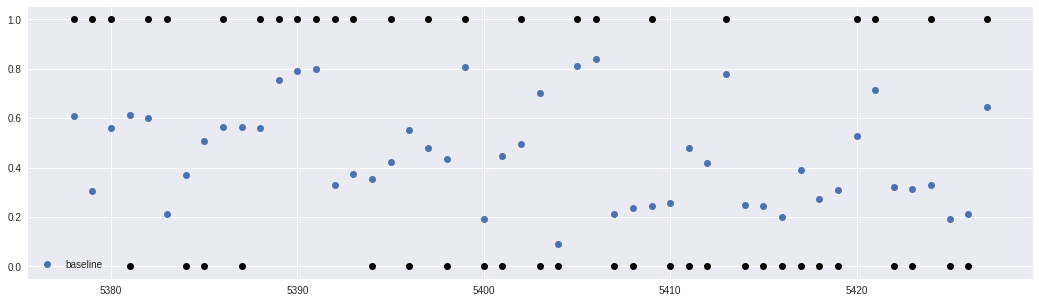

In [50]:
winwidth = 50
randidx = np.random.randint(0, len(obs_wl)-winwidth)
xrange = np.arange(randidx, randidx+50)

_, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.plot(xrange, obs_wl[xrange], 'ko')
plt.plot(xrange, ppc0['observed wl'].mean(axis=0)[xrange], 'x', label='baseline')
plt.legend();

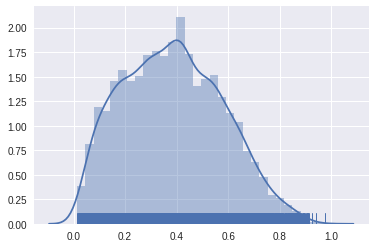

In [36]:
import seaborn as sns
sns.distplot(np.abs(obs_wl - ppc0['observed wl'].mean(axis=0)), 
             hist=True, rug=True, kde=True,
             # kde_kws={'bw':.15},
             );

## Team Intercept model

In [60]:
with pm.Model() as rating_model1:
    team_mu = pm.Normal('team_mu', 0., 1., shape=n_teams)
    time_rating = pm.Normal('rating_all', team_mu, 1., shape=(n_periods, n_teams))
    
    diff = time_rating[obs_period, obs_team_1] - time_rating[obs_period, obs_team_2]
    p = 0.5*pm.math.tanh(diff) + 0.5
    
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    
    trace1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [05:14<00:00,  5.55it/s]


In [61]:
ppc1 = pm.sample_ppc(trace1, samples=1000, model=rating_model1)

100%|██████████| 1000/1000 [00:00<00:00, 1202.38it/s]


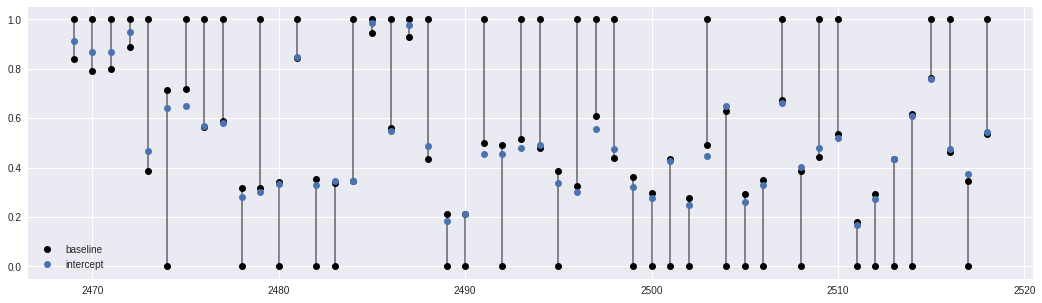

In [77]:
winwidth = 50
randidx = np.random.randint(0, len(obs_wl)-winwidth)
xrange = np.arange(randidx, randidx+50)

_, ax = plt.subplots(1, 1, figsize=(18, 5))
y0 = obs_wl[xrange]
y1 = ppc0['observed wl'].mean(axis=0)[xrange]
plt.plot(xrange, y0, 'ko')
plt.plot(xrange, y1, 'ko', label='baseline')
plt.plot([xrange, xrange], [y0, y1], 'k-', alpha=.5)
plt.plot(xrange, ppc1['observed wl'].mean(axis=0)[xrange], 'o', label='intercept')
plt.legend();

## Team Intercept with uniform decay model

In [93]:
with pm.Model() as rating_model2:
    rho = pm.Normal('rho', 0, 1)
    sd = pm.HalfCauchy('sigma', .5)
    mu = pm.Normal('rating_0', 0, 1., shape=n_teams)
    drift = pm.AR1('drift', k=rho, tau_e=sd**-2, shape=n_periods)
    time_rating = tt.outer(mu, drift)
    
    diff = time_rating[obs_team_1, obs_period] - time_rating[obs_team_2, obs_period]

    p = 0.5*pm.math.tanh(diff) + 0.5
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    trace2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [01:17<00:00, 25.89it/s]


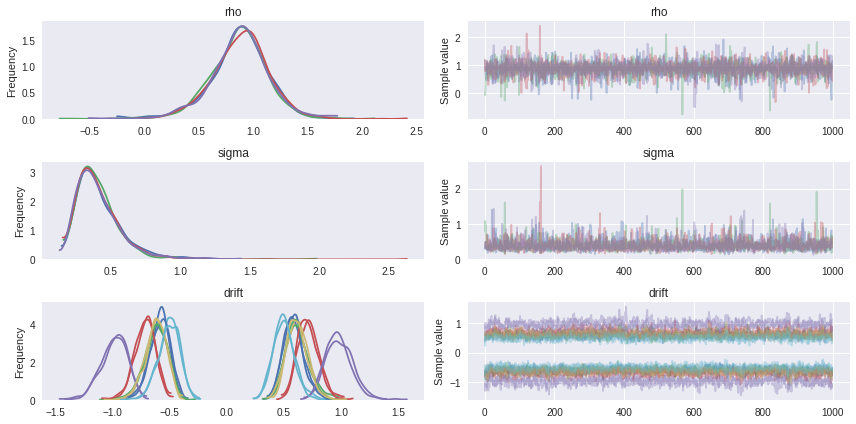

In [97]:
pm.traceplot(trace2, varnames=['rho', 'sigma', 'drift']);

In [98]:
ppc2 = pm.sample_ppc(trace2, samples=1000, model=rating_model2)

100%|██████████| 1000/1000 [00:00<00:00, 1266.97it/s]


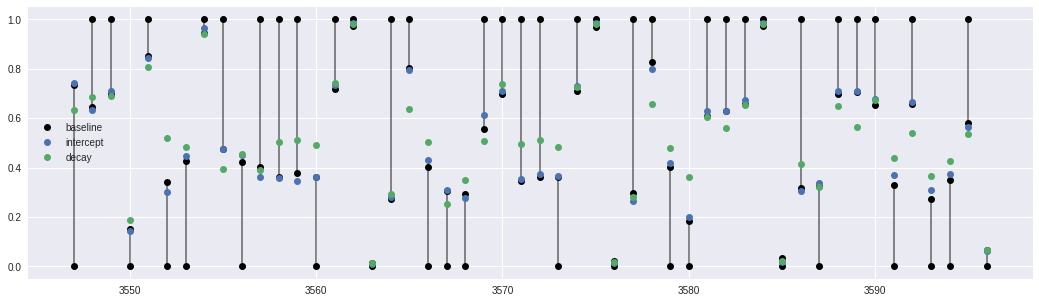

In [114]:
winwidth = 50
randidx = np.random.randint(0, len(obs_wl)-winwidth)
xrange = np.arange(randidx, randidx+50)

_, ax = plt.subplots(1, 1, figsize=(18, 5))
y0 = obs_wl[xrange]
y1 = ppc0['observed wl'].mean(axis=0)[xrange]
plt.plot(xrange, y0, 'ko')
plt.plot(xrange, y1, 'ko', label='baseline')
plt.plot([xrange, xrange], [y0, y1], 'k-', alpha=.5)
plt.plot(xrange, ppc1['observed wl'].mean(axis=0)[xrange], 'o', label='intercept')
plt.plot(xrange, ppc2['observed wl'].mean(axis=0)[xrange], 'o', label='decay')
plt.legend();

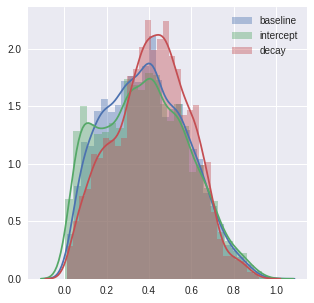

In [100]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
for ppc in [ppc0, ppc1, ppc2]:
    sns.distplot(np.abs(obs_wl - ppc['observed wl'].mean(axis=0)), 
                 hist=True, rug=False, kde=True,
                 # kde_kws={'bw':.15},
                 ax=ax)
plt.legend(["baseline", "intercept", "decay"]);

## Team Intercept with team decay model

In [ ]:
with pm.Model() as rating_model3:
    sd = pm.HalfCauchy('sigma', .5)
    mu = pm.Normal('rating_0', 0, 1., shape=n_teams)
    drift = pm.GaussianRandomWalk('drift',
                                  mu=0.,
                                  sd=sd, 
                                  shape=(n_periods, n_teams))
    time_rating = mu+drift
    diff = time_rating[obs_period, obs_team_1] - time_rating[obs_period, obs_team_2]

    p = 0.5*pm.math.tanh(diff) + 0.5
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    trace3 = pm.sample(1000, tune=1000)

In [98]:
ppc3 = pm.sample_ppc(trace3, samples=1000, model=rating_model3)

100%|██████████| 1000/1000 [00:00<00:00, 1266.97it/s]


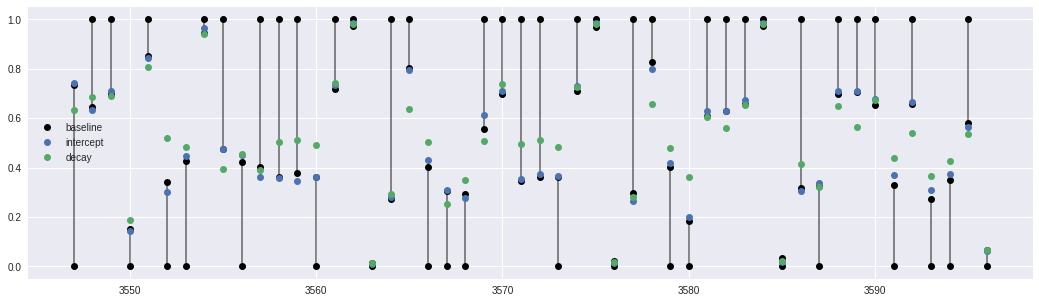

In [114]:
winwidth = 50
randidx = np.random.randint(0, len(obs_wl)-winwidth)
xrange = np.arange(randidx, randidx+50)

_, ax = plt.subplots(1, 1, figsize=(18, 5))
y0 = obs_wl[xrange]
y1 = ppc0['observed wl'].mean(axis=0)[xrange]
plt.plot(xrange, y0, 'ko')
plt.plot(xrange, y1, 'ko', label='baseline')
plt.plot([xrange, xrange], [y0, y1], 'k-', alpha=.5)
plt.plot(xrange, ppc1['observed wl'].mean(axis=0)[xrange], 'o', label='intercept')
plt.plot(xrange, ppc2['observed wl'].mean(axis=0)[xrange], 'o', label='decay')
plt.plot(xrange, ppc3['observed wl'].mean(axis=0)[xrange], 'o', label='random walk')
plt.legend();

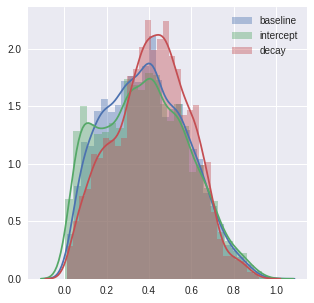

In [100]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
for ppc in [ppc0, ppc1, ppc2, ppc3]:
    sns.distplot(np.abs(obs_wl - ppc['observed wl'].mean(axis=0)), 
                 hist=True, rug=False, kde=True,
                 # kde_kws={'bw':.15},
                 ax=ax)
plt.legend(["baseline", "intercept", "decay", "random walk"]);

## 

In [12]:
with pm.Model() as rating_model2:
    rho = pm.Beta('rho', 5, 8)
    omega = pm.HalfCauchy('omega', .5, shape=n_teams) # I dont think this is really necessary. 
    sd = pm.HalfCauchy('sigma', .5)
    mu = pm.Normal('rating_0', 0, 1., shape=n_teams)
    drift = pm.AR1('drift', k=rho, tau_e=sd**-2, shape=n_periods)
    time_rating = tt.outer(mu*omega, drift+1)
    
    diff = time_rating[obs_team_1, obs_period] - time_rating[obs_team_2, obs_period]

    p = 0.5*pm.math.tanh(diff) + 0.5
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    trace2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
 83%|████████▎ | 1660/2000 [14:44<03:05,  1.83it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 68 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 87%|████████▋ | 1742/2000 [15:20<02:07,  2.03it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 72 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [17:08<00:00,  1.97it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 51 diverging samples after tuning. If increasing `target_accept` does not help try to reparameteriz

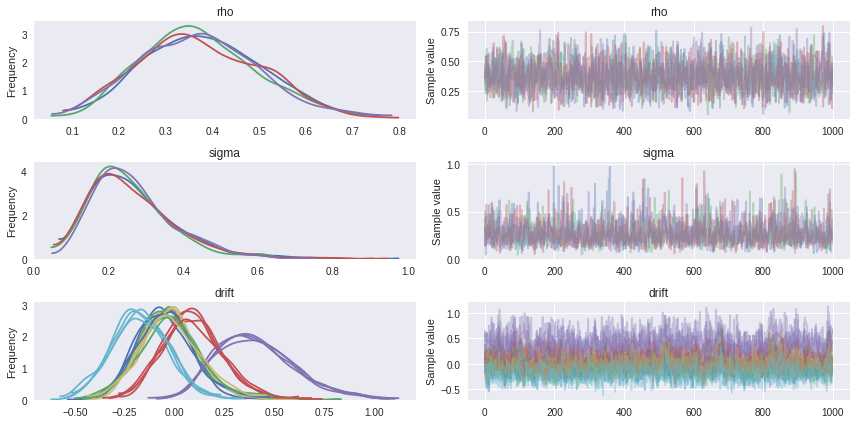

In [13]:
pm.traceplot(trace2, varnames=['rho', 'sigma', 'drift']);

In [37]:
ppc2 = pm.sample_ppc(trace2, samples=1000, model=rating_model2)

100%|██████████| 1000/1000 [00:00<00:00, 1228.45it/s]


In [30]:
with pm.Model() as rating_model1:
    rho = pm.Beta('rho', 5, 8)
    omega = pm.HalfCauchy('omega', 0.5, shape=n_teams)
    sigma = pm.HalfCauchy('sigma', 0.5)
    time_rating = [pm.Normal('rating_0', 0, omega, shape=n_teams)]
    for i in np.arange(1, n_periods):
        time_rating.append(pm.Normal('rating_'+str(i), rho*time_rating[i-1], sigma, shape=n_teams))
    time_rating = tt.stack(time_rating)
    
    diff = time_rating[obs_period, obs_team_1] - time_rating[obs_period, obs_team_2]

    p = 0.5*pm.math.tanh(diff) + 0.5
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    
    trace1 = pm.sample(1000, tune=1000)

(5757,)

In [ ]:
pm.traceplot(trace1, varnames=['rho', 'sigma', 'omega']);

In [ ]:
with pm.Model() as rating_model3:
    rho = pm.Beta('rho', 5, 8)
    omega = pm.HalfCauchy('omega', 2, shape=n_teams)
    sd = pm.HalfCauchy('sigma', 2)
    
    def AR1_vec(value):
        """vector version of AR1
        """
        x_im1 = value[:, :-1]
        x_i = value[:, 1:]
        boundary = pm.Normal.dist(0, sd=omega).logp # logp for rating_0
        innov_like = pm.Normal.dist(rho * x_im1, sd=sd).logp(x_i)
        return boundary(value[:, 0]) + tt.sum(innov_like)
    
    time_rating = pm.DensityDist('time_rating', 
                                 AR1_vec, 
                                 shape=(n_teams, n_periods))
    
    diff = time_rating[obs_team_1, obs_period] - time_rating[obs_team_2, obs_period]

    p = 0.5*pm.math.tanh(diff) + 0.5
    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)
    trace3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
Average Loss = -2.8968e+06: 100%|██████████| 200000/200000 [07:16<00:00, 458.15it/s]
Finished [100%]: Average Loss = -2.8968e+06
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = -2.8968e+06
INFO (theano.gof.compilelock): Refreshing lock /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
  1%|▏         | 28/

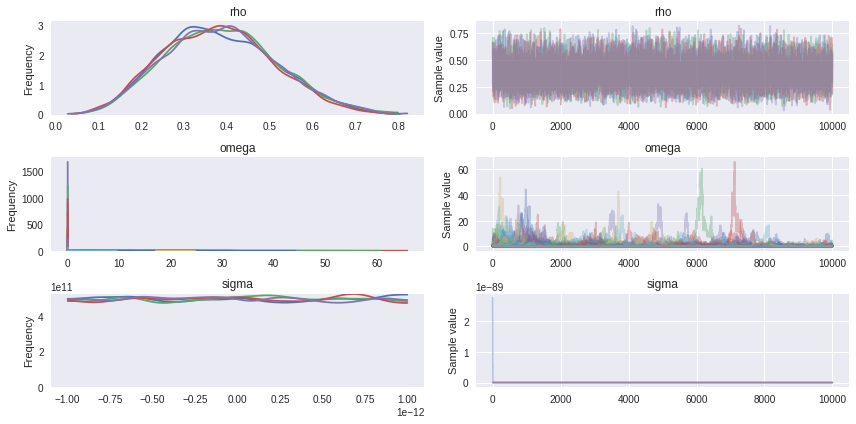

In [40]:
pm.traceplot(trace3, varnames=['rho', 'omega', 'sigma']);

In [10]:
# try approximating instead
with rating_model:
    approx = pm.fit(20000, method='nfvi')
    ap_trace = approx.sample(1000)

Average Loss = 4,242.5: 100%|███████████████████████████████████████████████████| 20000/20000 [01:04<00:00, 307.75it/s]
Finished [100%]: Average Loss = 4,242.1


# Plot the last period rating for some teams

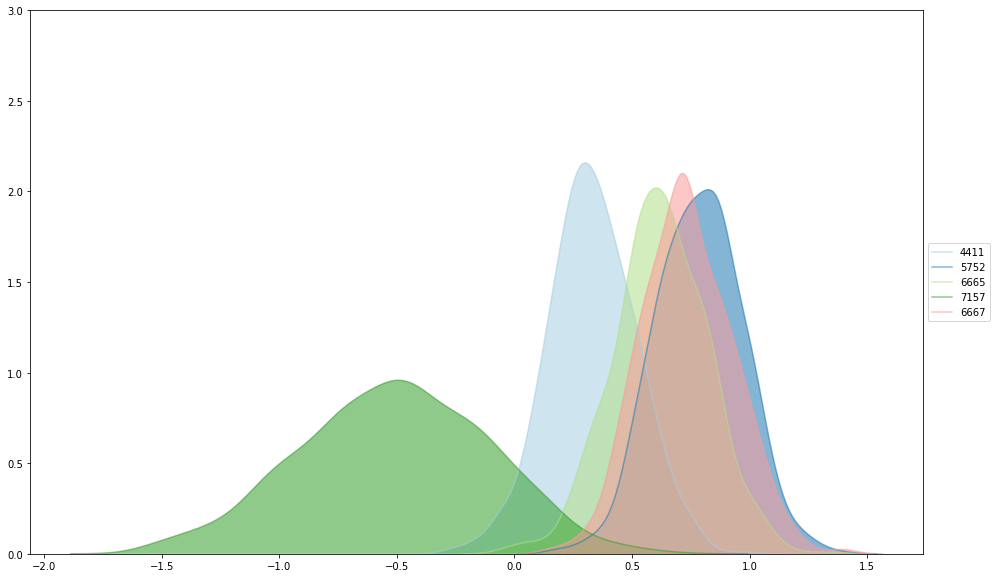

In [17]:
sns.set_palette('Paired', n_teams)
f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,3.0)
[sns.kdeplot(trace['rating_%s'%max(obs_period)][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in [4411, 5752, 6665, 7157, 6667] ]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Plot some over time ratings

C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


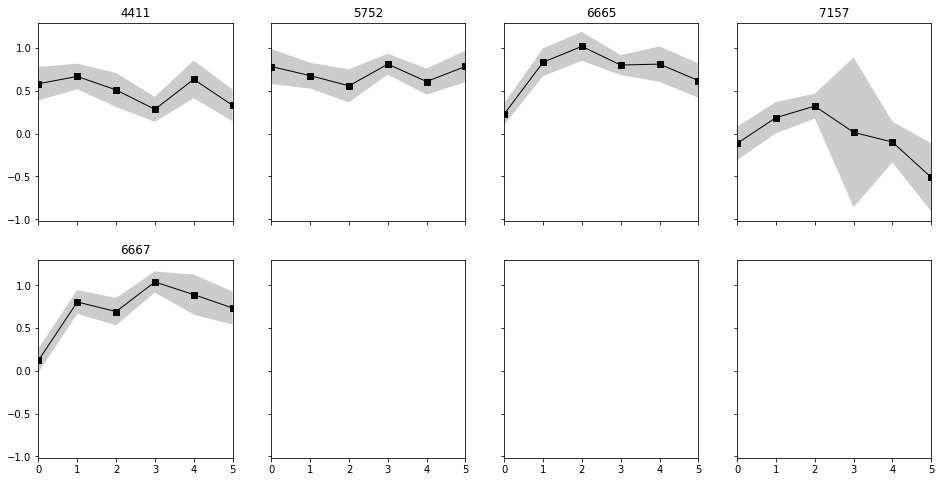

In [21]:
num_rows = int(np.ceil(len([4411, 5752, 6665, 7157, 6667])/4))
f, ax = plt.subplots(num_rows, 4, figsize=(16,8), sharex=True, sharey=True)
ax = ax.flatten()
condensed_ratings = {j: np.vstack([trace['rating_'+str(i)][:,tmap[j]] for i in range(n_periods)]).T for j in [4411, 5752, 6665, 7157, 6667]}
for i,j in enumerate([4411, 5752, 6665, 7157, 6667]):
    ax[i].set_title(j)
    sns.tsplot(condensed_ratings[j], color='black', ci='sd', ax=ax[i], marker='s', linewidth=1)